# How to work with this

To execute a cell just press the  "Shift" + "return".

If you do that with the cell below you can just press the button to execute all cells.

In [1]:
%%HTML
<button id="do_run_all">Click to run all</button>
<script>
$("#do_run_all").click(
    function () {
        $("#run_all_cells").click();
    }
);
</script>

# This is just to adjust the browser window size

In [13]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# The actual code starts here

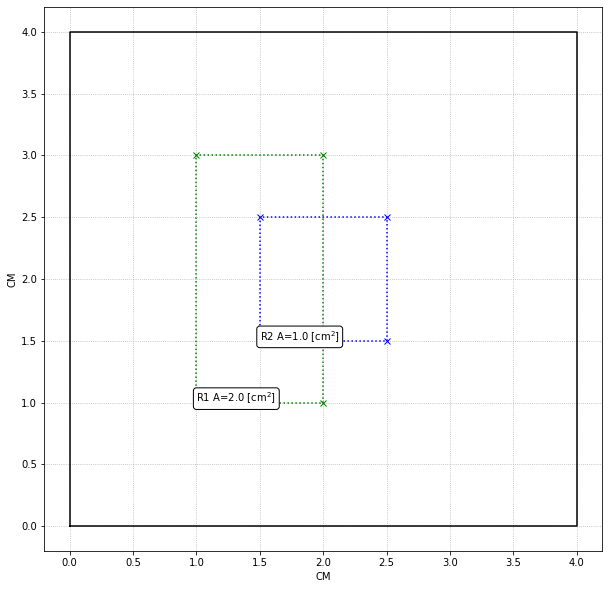

In [85]:
from matplotlib import pyplot as plt
import numpy as np

class Shape:
    """
        Base class for "shape".
        The coordinate system allows only x, y > 0 parameters.
    """
    def __init__(self, number=0, orientation=0, name="", color="k"):

        self.number = number #  just to count things
        self.orientation = orientation # 0: normal, pi: rotated by 90 degrees
        self.name = name
        
        # sequential series of points defininig the shape 
        # For example "Rectangle" needs 5 for 4 corners because the plotting 
        # has to draw another line from the last coordinate to the origin, 
        # so the last entry in the list and the first are the same
        # TODO implement when inheriting from this class
        self.sequential_x = []
        self.sequential_y = []
        self.sequential_points = zip(self.sequential_x, self.sequential_y) # just above as tuples
        
        # plot options
        self.color=color
    
    def all_coords_positive(self):
        return all([coord>=0 for coord in self.sequential_x]) and all([coord>=0 for coord in self.sequential_y])
    
    def is_valid(self):
        return self.all_coords_positive()
    
    def get_size(self):
        """ Integral over the shape """
        raise NotImplementedError(self.__class__.__name__ + ' get_size NOT IMPLEMENTED')
    
    def __str__(self):
        return f"Shape: {self.name} {self.get_size():0.2f}[cm^2] points: {self.sequential_points}"

    def plot_on(self, ax, ls=":", marker="x",annotate=False):
        """
        Draw the outlines of the square.
        The line follows the order of points.
        """
        ax.plot(self.sequential_x, self.sequential_y, color=self.color, ls=ls, marker=marker)
        if annotate:
            ax.text(self.sequential_x[0], self.sequential_y[0], 
                    fr"{self.name} A={self.get_size():0.1f} [cm$^2$]", bbox=dict(boxstyle="round", fc="w"))
            

class Rectangle(Shape):
    """
        Rectangular implementation of "shape"
        Will be used for the master sheet, that is the sheet we cut out of.
        Will also be the first testing shape to implement the optimizer.
        
    """
    def __init__(self, lower_xy, upper_xy, *args, **kwargs):
        """
            We define a square using the bottom left and top right corners.
        """
        super(Rectangle, self).__init__(*args, **kwargs)

        # sequential coordinates are easier to deal with with complex shapes and plotting
        self.sequential_x = [lower_xy[0], upper_xy[0], upper_xy[0], lower_xy[0]]
        self.sequential_x.append(self.sequential_x[0]) 
        
        self.sequential_y = [lower_xy[1], lower_xy[1], upper_xy[1], upper_xy[1]]
        self.sequential_y.append(self.sequential_y[0]) 
        
        self.sequential_points = zip(self.sequential_x, self.sequential_y)
        
        self.max_x = max(self.sequential_x); self.min_x = min(self.sequential_x);
        self.max_y = max(self.sequential_y); self.min_y = min(self.sequential_y);
        
        assert self.is_valid(), f"{self.__class__.__name__}::ERROR::Invalid coordinates: {self.sequential_x} {self.sequential_y}."
        
    def get_size(self):
        """ Easy for squares: A = a*b """
        return abs(self.sequential_x[2] - self.sequential_x[0] ) * abs(self.sequential_y[2] - self.sequential_y[0] )

    def overlaps_with(self, other_shape):
        """ at least one point of shape is within this shape """
        for x, y in other_shape.sequential_points:
            if x<self.max_x and x>self.min_x and y>self.min_y and y<self.max_y:
                print(f"{self.__class__.__name__}::Warning {self.name} overlaps with {other_shape.name}")
                return True # found a point that is in this square
        return False
    
    def contains(self, other):
        """ Is "other" completly contained in this Rectangle"""
        for x, y in other_shape.sequential_points:
            if x > self.max_x or x < self.min_x or y > self.max_y or y < self.min_y:
                return False # found a point that is NOT in this square
        return True
    
 
class Plotter:
    """
        Manages plotting the results
    """
    def __init__(self, shapes=[Rectangle((0,0),(1,1), name="Master_sheet",)], figsize=(10, 10)):
        self.shapes = shapes
        self.f, self.ax = plt.subplots(figsize=figsize)
        
        # the first shape we expect to be the master sheet or canvas that all
        # other shapes will be drawn into
        self.canvas = shapes[0]
        
    def plot(self, shapes=None, ls=":", marker ="x", grid=True, annotate=False):
        
        if shapes:
            self.shapes = shapes
        if grid:
            self.ax.grid(ls=":")
            
        self.canvas.plot_on(self.ax, marker=None, ls='solid')
        for r in self.shapes[1:]: # skip first one which is the "master sheet" or "canvas"
            assert r.is_valid(), f"{self.__class__.__name__}::Rectangle Coordinates are invalid."
            r.plot_on(self.ax, ls=ls, marker=marker, annotate=annotate)
        self.ax.set_xlabel("CM")
        self.ax.set_ylabel("CM")
        
    def set_shapess(self, shapes):
        self.shapess = shapes
        
    def add_shapes(shapes):
        self.shapes.append(shapes)
        

r0 = Rectangle((0,0),(4,4), name="Master_sheet")
r1 = Rectangle((1, 1), (2, 3), name="R1", color="g",)
r2 = Rectangle((1.5, 1.5), (2.5, 2.5),  name="R2", color="b",)
shapes = [r0, r1, r2]

plotter = Plotter(shapes = shapes)
plotter.plot(annotate=True)

ShapeManager:: Warning using manually set shapes. For testing/debugging.
Rectangle::Warning R1 overlaps with R2
Rectangle::Warning R3 overlaps with R2


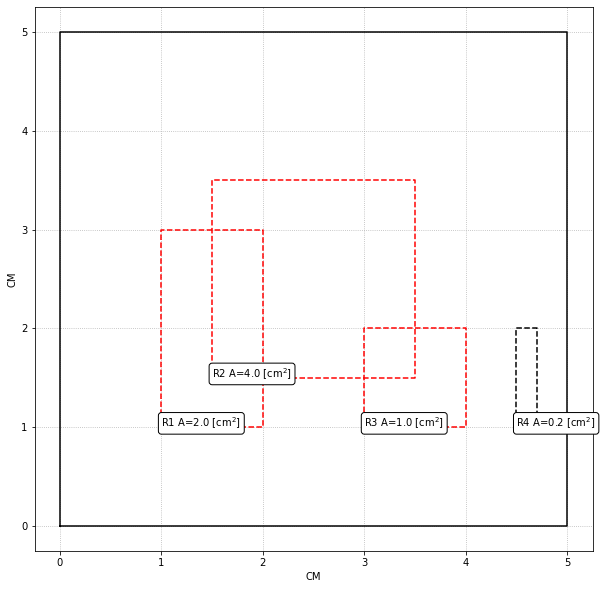

In [86]:
class Config:
    """
        Configuration object to configure everything.
    """
    def __init__(self, sheet_size, file_name, annotate_plot, plot_markers, plots_ls):
        self.file_name = file_name # file with shapes data
        self.sheet_size = sheet_size # max x and y of the aluminium 2d sheet
        self.annotate_plot = annotate_plot
        self.plot_markers = plot_markers
        self.plots_ls = plots_ls

class ShapeManager:
    """
        Manages everything:
            - loads shapes
            - calls optimizer
            - plots results
    """
    def __init__(self, config=None):
        assert config, f"{self.__class__.__name__}:: No configuration specified!"
        self.config = config
        self.master_sheet = Rectangle((0,0), self.config.sheet_size, name="Master_sheet")
        self.shapes=[]
        # self.shapes = self.read_file(self.config.file_name)
        self.sort_shapes_by_size()
        self.shapes.insert(0, self.master_sheet)
          
    def set_shapes(self, shapes):
        print(f"{self.__class__.__name__}:: Warning using manually set shapes. For testing/debugging.")
        self.shapes = shapes
        self.sort_shapes_by_size()
        self.shapes.insert(0, self.master_sheet)
        
    def read_file(self, file_name):
        raise NotImplementedError(self.__class__.__name__ + ' read_file NOT IMPLEMENTED')
        self.sort_shapes_by_size()
    
    def check_overlap_of_shapes(self):
        """
        Go through the shapes and check that no corner is in another shape.
        """
        overlap = False
        for i, shape in enumerate(self.shapes):
            for j, other_shape in enumerate(self.shapes):
                # self overlap is always the case, and we dont need to check twice
                if j>=i : continue
                if shape.overlaps_with(other_shape):
                    other_shape.color = "r"
                    shape.color = "r"
                    overlap =  True
                # print(f"{self.__class__.__name__}::Checking .{shape.name}. against .{other_shape.name}. {overlap}")
        return overlap
    
    def sort_shapes_by_size(self, largest_first=True):
        """
        Sort shapes by size. Largest First.
        """
        self.shapes.sort(key = lambda x: x.get_size(), reverse=largest_first)

    
    def plot_results(self):
        alu = Plotter(shapes = self.shapes,)
        alu.plot(annotate=self.config.annotate_plot, 
                 marker=self.config.plot_markers,
                 ls=self.config.plots_ls
                )
        
        
config = Config(sheet_size = (5, 5),
                file_name = "Placeholder.INVALID",
                annotate_plot = True, 
                plot_markers = None,
                plots_ls = "--"
               )       

manager = ShapeManager(config=config)

r1 = Rectangle((1, 1), (2, 3), name="R1")
r2 = Rectangle((1.5, 1.5), (3.5, 3.5), name="R2")
r3 = Rectangle((3, 1), (4, 2), name="R3")
r4 = Rectangle((4.5, 1), (4.7, 2), name="R4")
manager.set_shapes([r1, r2, r3, r4])

is_overlap = manager.check_overlap_of_shapes()
assert is_overlap, "OVerlap not detected"
manager.plot_results() 
#for s in manager.shapes : print(s)